Check out the Jupyter notebook for Chapter 10 at https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter10_dl-for-timeseries.ipynb. It has tried 7 methods for the temperature prediction problem: Try 1 (A common-sense, non-machine learning baseline method), Try 2 (A fully connected neural network), Try 3 (1-d convolutional neural networks), Try 4 (Recurrent neural network), Try 5 (LSTM with recurrent dropout), Try 6 (stacking RNN layers), Try 7 (Bidirectional RNN).

**Your task: use the above 7 methods to predict the temperature in 48 hours (instead of 24 hours). In the Jupyter notebook, include your code as well as the performance of the 7 methods.**    

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-03-10 18:32:06--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.114.21, 52.217.234.48, 54.231.132.56, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.114.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.7MB/s    in 0.9s    

2023-03-10 18:32:07 (13.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

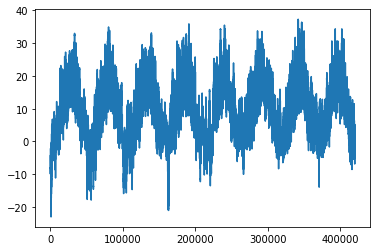

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

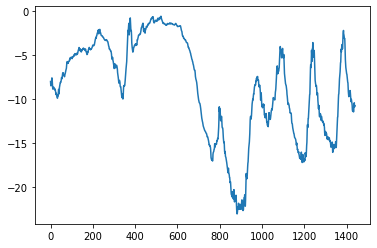

In [ ]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 48 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 3.21
Test MAE: 3.47


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 16s 14ms/step - loss: 17.1093 - mae: 3.2588 - val_loss: 17.7978 - val_mae: 3.3219
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 13.2137 - mae: 2.8879 - val_loss: 17.3424 - val_mae: 3.3019
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 12.4225 - mae: 2.7990 - val_loss: 17.9877 - val_mae: 3.3555
Epoch 4/10
819/819 [==============================] - 11s 14ms/step - loss: 11.8362 - mae: 2.7291 - val_loss: 17.3047 - val_mae: 3.2823
Epoch 5/10
819/819 [==============================] - 11s 14ms/step - loss: 11.4204 - mae: 2.6788 - val_loss: 18.8822 - val_mae: 3.4408
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 11.1167 - mae: 2.6385 - val_loss: 17.3614 - val_mae: 3.2993
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 10.8061 - mae: 2.6002 - val_loss: 19.0143 - val_mae: 3.4541
Epoch 8/10
819/819 [============================

**Plotting results**

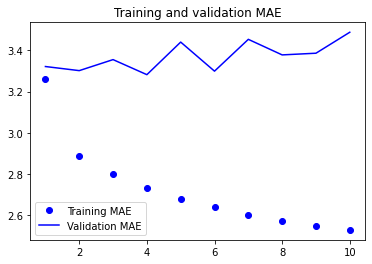

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 48, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 15ms/step - loss: 21.2017 - mae: 3.6255 - val_loss: 18.6302 - val_mae: 3.4292
Epoch 2/10
819/819 [==============================] - 12s 14ms/step - loss: 15.8384 - mae: 3.1730 - val_loss: 19.9747 - val_mae: 3.5457
Epoch 3/10
819/819 [==============================] - 12s 14ms/step - loss: 14.2709 - mae: 3.0018 - val_loss: 21.9780 - val_mae: 3.7382
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 13.1589 - mae: 2.8759 - val_loss: 20.3852 - val_mae: 3.5929
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 12.3744 - mae: 2.7841 - val_loss: 21.5722 - val_mae: 3.6672
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 11.6343 - mae: 2.6969 - val_loss: 21.6138 - val_mae: 3.6712
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 11.1082 - mae: 2.6346 - val_loss: 20.3732 - val_mae: 3.5914
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 15ms/step - loss: 42.5423 - mae: 4.8765 - val_loss: 17.4938 - val_mae: 3.2466
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 16.4131 - mae: 3.1772 - val_loss: 15.2662 - val_mae: 3.0669
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 14.5038 - mae: 2.9976 - val_loss: 15.4450 - val_mae: 3.0829
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 13.7027 - mae: 2.9158 - val_loss: 15.6454 - val_mae: 3.0882
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 13.1773 - mae: 2.8541 - val_loss: 16.5772 - val_mae: 3.1700
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 12.7981 - mae: 2.8107 - val_loss: 16.7797 - val_mae: 3.1878
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 12.5061 - mae: 2.7767 - val_loss: 17.1084 - val_mae: 3.2309
Epoch 8/10
819/819 [============================

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 247s 298ms/step - loss: 34.6926 - mae: 4.4447 - val_loss: 15.9084 - val_mae: 3.0908
Epoch 2/50
819/819 [==============================] - 245s 299ms/step - loss: 20.0996 - mae: 3.5107 - val_loss: 16.1831 - val_mae: 3.1284
Epoch 3/50
819/819 [==============================] - 245s 299ms/step - loss: 18.6980 - mae: 3.3788 - val_loss: 15.4834 - val_mae: 3.0620
Epoch 4/50
819/819 [==============================] - 245s 299ms/step - loss: 17.7649 - mae: 3.2906 - val_loss: 15.7315 - val_mae: 3.0795
Epoch 5/50
819/819 [==============================] - 245s 299ms/step - loss: 17.0596 - mae: 3.2239 - val_loss: 16.0700 - val_mae: 3.1329
Epoch 6/50
819/819 [==============================] - 245s 299ms/step - loss: 16.4092 - mae: 3.1566 - val_loss: 16.0516 - val_mae: 3.1551
Epoch 7/50
819/819 [==============================] - 244s 298ms/step - loss: 15.9745 - mae: 3.1123 - val_loss: 16.1927 - val_mae: 3.1672
Epoch 8/50
819/819 [==============

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 474s 573ms/step - loss: 28.1763 - mae: 4.0699 - val_loss: 14.9491 - val_mae: 3.0291
Epoch 2/50
819/819 [==============================] - 469s 572ms/step - loss: 19.0813 - mae: 3.4254 - val_loss: 15.5210 - val_mae: 3.0614
Epoch 3/50
819/819 [==============================] - 467s 569ms/step - loss: 17.6164 - mae: 3.2943 - val_loss: 16.1762 - val_mae: 3.1165
Epoch 4/50
819/819 [==============================] - 468s 571ms/step - loss: 16.4794 - mae: 3.1815 - val_loss: 15.6402 - val_mae: 3.1026
Epoch 5/50
819/819 [==============================] - 468s 571ms/step - loss: 15.5648 - mae: 3.0886 - val_loss: 16.4235 - val_mae: 3.1747
Epoch 6/50
819/819 [==============================] - 467s 570ms/step - loss: 14.7531 - mae: 3.0032 - val_loss: 17.0680 - val_mae: 3.2184
Epoch 7/50
819/819 [==============================] - 468s 571ms/step - loss: 13.9623 - mae: 2.9172 - val_loss: 16.1594 - val_mae: 3.1899
Epoch 8/50
819/819 [==============

404/404 [==============================] - 30s 72ms/step - loss: 16.8290 - mae: 3.2270
Test MAE: 3.23


### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 30.3411 - mae: 4.0786 - val_loss: 16.5025 - val_mae: 3.1747
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 14.3265 - mae: 2.9850 - val_loss: 16.3466 - val_mae: 3.1525
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 13.0822 - mae: 2.8527 - val_loss: 16.6102 - val_mae: 3.1824
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 12.3239 - mae: 2.7644 - val_loss: 17.0679 - val_mae: 3.2374
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 11.8000 - mae: 2.7011 - val_loss: 17.0512 - val_mae: 3.2249
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 11.3474 - mae: 2.6410 - val_loss: 18.2240 - val_mae: 3.3458
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 10.8057 - mae: 2.5716 - val_loss: 18.6606 - val_mae: 3.3820
Epoch 8/10
819/819 [============================

### Going even further

## Summary